## AirBnB Seattle Analysis with CRISP-DM (Cross Industry Standard Process for Data Mining) 

A brief analysis example using CRISP-DM methodology. This methodology suggest a data analysis in the following steps:

* Business Understanding
* Data understanding
* Data Preparation
* Modeling
* Evaluation
* Deployment

### Business Understanding

Imagine that you have a room or an appartment in Seattle and you would like to offer it via Airbnb. In order o help you to make an initial setup and list it in Airbnb. You would like to know some simple insights of the Airbnb market. The following questions represent in general a good overview of the Airbnb market.

* What is the relation room type and part of the city with the price?
* Is there a price difference between room type and the bed type?
* Are bathrooms or bedrooms important perks to influence the price?
* What are the top amenities offered?
* What months are cheaper to visit Seattle?
* What are features or characteristics that influence in the price of a room?

In [89]:
# Here I just add some libraries, which will be useful during the process.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder,OneHotEncoder,StandardScaler 
import sklearn.metrics as mtr
import math
%matplotlib inline

### Data Understanding

Second step is to explore the data and based on the [AirBnB Seattle Dataset](https://www.kaggle.com/airbnb/seattle/data), we will get mainly three datasets, which we will analyse:

* calendar.csv ==> Booking information of houses in Seattle.
* listings.csv ==> Information of houses in Seattle.
* reviews.csv ==> Reviews of houses in Seattle.


In [90]:
# Loading the datasets in pandas

df_calendar = pd.read_csv('datasets/calendar.csv')
df_reviews = pd.read_csv('datasets/reviews.csv')
df_listings = pd.read_csv('datasets/listings.csv')

print('The dataset calendar has {} rows and {} columns.'.format(df_calendar.shape[0], df_calendar.shape[1]))
print('The dataset reviews has {} rows and {} columns.'.format(df_reviews.shape[0], df_reviews.shape[1]))
print('The dataset listings has {} rows and {} columns.'.format(df_listings.shape[0], df_listings.shape[1]))

The dataset calendar has 1393570 rows and 4 columns.
The dataset reviews has 84849 rows and 6 columns.
The dataset listings has 3818 rows and 92 columns.


#### Data Cleaning & Exploration Strategy 
Based on the size of the datasets, we see that the calendar has most of the entries and the listings has most of the columns or features. 

The first step will be to get a sample of the first 5 rows in three datasets, in order to see the information provided and searh for information that can help us to answer the business questions.

Then in a further step, we will proceed to discard or impute some values, depending of the information needed.

In [91]:
df_calendar.head(5)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [92]:
# Now lets take a look on the null values contained in the dataframe
null_ratio_calendar = df_calendar.isnull().sum()/df_calendar.shape[0]
null_ratio_calendar

listing_id    0.00000
date          0.00000
available     0.00000
price         0.32939
dtype: float64

It looks like the price has a 32.93% ratio of missing values, in this case, it may be convenient to drop them.

In [93]:
df_reviews.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [6]:
null_ratio_reviews = df_reviews.isnull().sum()/df_reviews.shape[0]
null_ratio_reviews

listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
comments         0.000212
dtype: float64

Here the percentage of people, who do not leave a comment is very low. It seems that most of the guests hasve always something to mention about their experience.

In [7]:
df_listings.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [32]:
pd.set_option('display.max_rows', 92)
null_ratio_listings = df_listings.isnull().sum()/df_listings.shape[0]
null_ratio_listings.sort_values(ascending=False)

license                             1.000000
square_feet                         0.974594
monthly_price                       0.602672
security_deposit                    0.511262
weekly_price                        0.473808
notes                               0.420639
neighborhood_overview               0.270299
cleaning_fee                        0.269775
transit                             0.244631
host_about                          0.224987
host_acceptance_rate                0.202462
review_scores_accuracy              0.172342
review_scores_checkin               0.172342
review_scores_value                 0.171818
review_scores_location              0.171556
review_scores_cleanliness           0.171032
review_scores_communication         0.170508
review_scores_rating                0.169460
reviews_per_month                   0.164222
first_review                        0.164222
last_review                         0.164222
space                               0.149031
host_respo

In [9]:
# For the listings data, I get more curious and I would like to know, how many columns do not have null values?
no_null_listings = set(df_listings.columns[df_listings.isnull().mean()==0])
no_null_listings

{'accommodates',
 'amenities',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'bed_type',
 'calculated_host_listings_count',
 'calendar_last_scraped',
 'calendar_updated',
 'cancellation_policy',
 'city',
 'country',
 'country_code',
 'description',
 'experiences_offered',
 'extra_people',
 'guests_included',
 'has_availability',
 'host_id',
 'host_url',
 'host_verifications',
 'id',
 'instant_bookable',
 'is_location_exact',
 'jurisdiction_names',
 'last_scraped',
 'latitude',
 'listing_url',
 'longitude',
 'market',
 'maximum_nights',
 'minimum_nights',
 'name',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'number_of_reviews',
 'picture_url',
 'price',
 'require_guest_phone_verification',
 'require_guest_profile_picture',
 'requires_license',
 'room_type',
 'scrape_id',
 'smart_location',
 'state',
 'street'}

This is great and simplify our work since we can use only the listings dataframe to answer most of our business questions.

### Data Preparation & Questions

The first set of questions 1-4 will be answered while we prepare the data and later in order to answer the last question. It is important to move into the modeling in the next section.

#### What is the price relation between room type and suburb of the city?

/Users/pepe/anaconda3/envs/python3_new/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 35199 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pepe/anaconda3/envs/python3_new/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 38597 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pepe/anaconda3/envs/python3_new/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 22270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pepe/anaconda3/envs/python3_new/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 35199 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/pepe/anaconda3/envs/python3_new/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 38597 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/pe

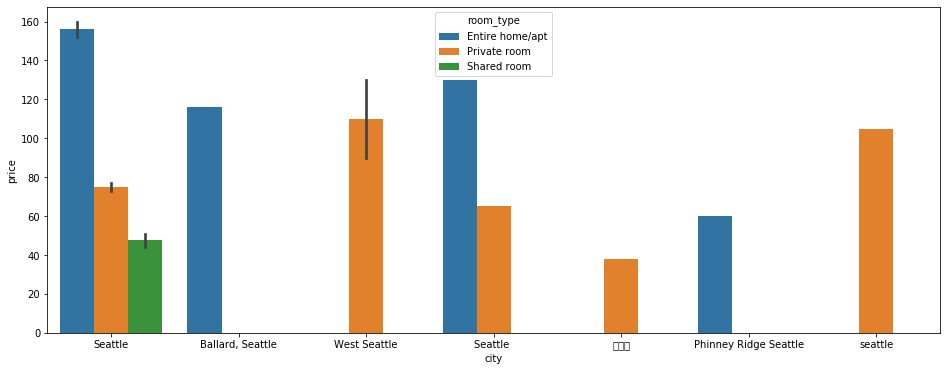

In [94]:
df_listings['price'] = df_listings['price'].replace(r'[$,%]', '', regex = True).astype(float)
plt.figure(figsize=(16, 6))
sns.barplot(x="city", y="price", hue="room_type", data=df_listings)

In general Seattle city and Seattle are the locations in which the major appartment concentration is located. It is quite inresting to see that the offer for shared rooms is very limited. Which implies that privacy is important.

In [11]:
# What is the place with special characters?
df_listings.groupby('city').count()

# It is 西雅图 = Seattle in chinesse

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
city,,,,,,,,,,,,,,,,,,,,,
"Ballard, Seattle",1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
Phinney Ridge Seattle,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
Seattle,3810,3810,3810,3810,3810,3633,3243,3810,3810,2779,...,3155,3810,0,3810,3810,3810,3810,3810,3810,3184
Seattle,2,2,2,2,2,2,1,2,2,2,...,2,2,0,2,2,2,2,2,2,2
West Seattle,2,2,2,2,2,2,2,2,2,2,...,2,2,0,2,2,2,2,2,2,2
seattle,1,1,1,1,1,1,0,1,1,0,...,0,1,0,1,1,1,1,1,1,0
西雅图,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1


It seems that there is a very small niche for only chinesse speakers

#### Is there a price difference between room type and bed type?

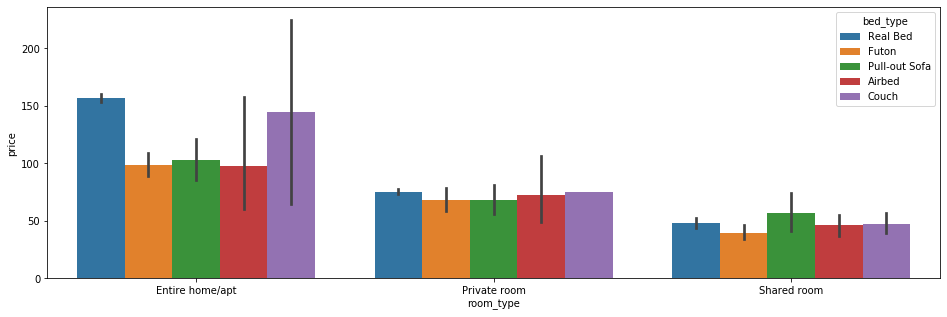

In [102]:
plt.figure(figsize=(16, 5))
sns.barplot(x="room_type", y="price", hue="bed_type", data=df_listings)

There is not a significant difference between the bed material and the room type. Couch and real bed in appartments do not have any significant difference in price. This may indicates that the price is not driven by the bed quality.

#### Are the number of bathrooms or bedrooms important perks to influence the price?

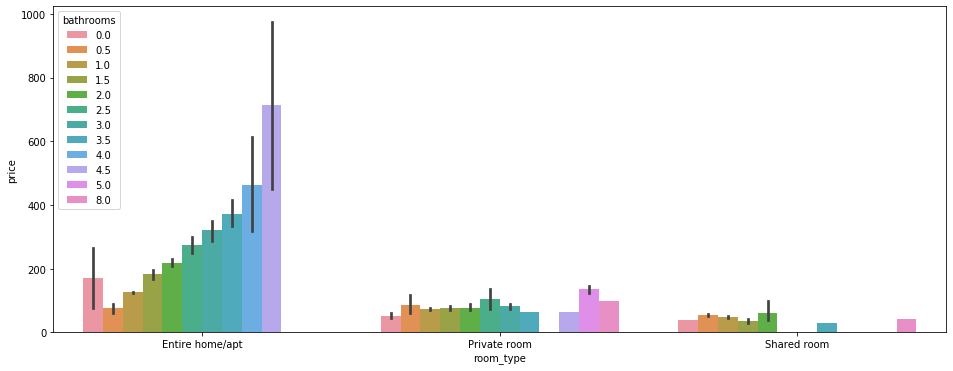

In [70]:
plt.figure(figsize=(16, 6))
sns.barplot(x="room_type", y="price", hue="bathrooms", data=df_listings)

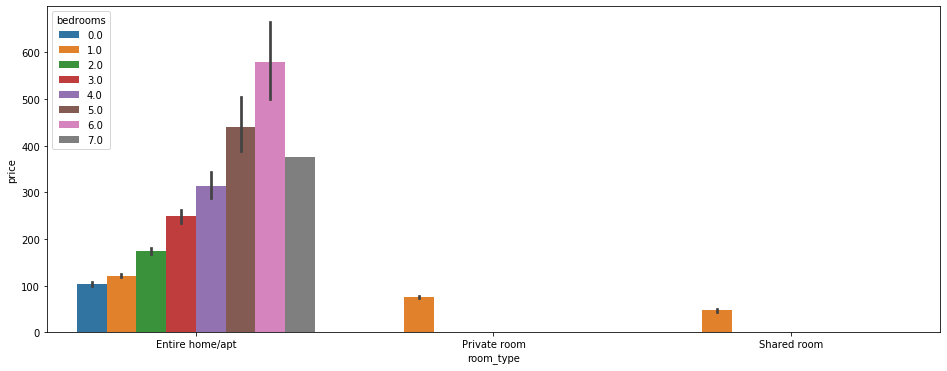

In [71]:
plt.figure(figsize=(16, 6))
sns.barplot(x="room_type", y="price", hue="bedrooms", data=df_listings)

It seems that there is a high correlation between the number of bedrooms and bathrooms, It is significant in the entire home/apt category.

#### What is the proportion of min and max nights offered in the Seattle Airbnb market? (Bonus)

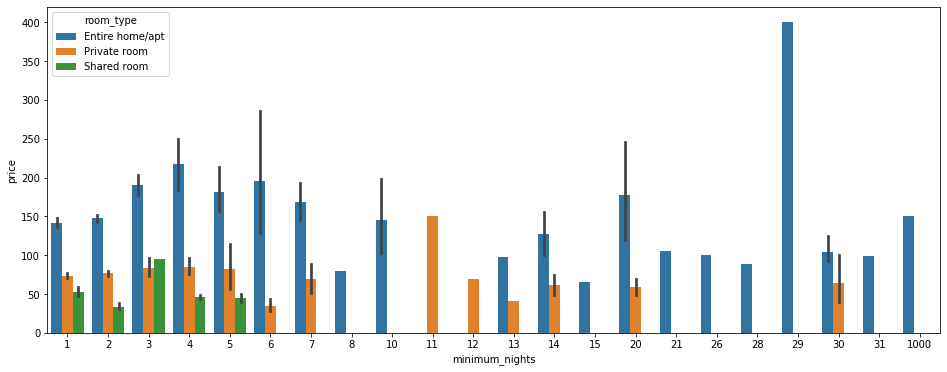

In [37]:
plt.figure(figsize=(16, 6))
sns.barplot(x="minimum_nights", y="price", hue="room_type", data=df_listings)

There not a clear pattern of min recommended number of nights

#### Price vs Guest included by room type

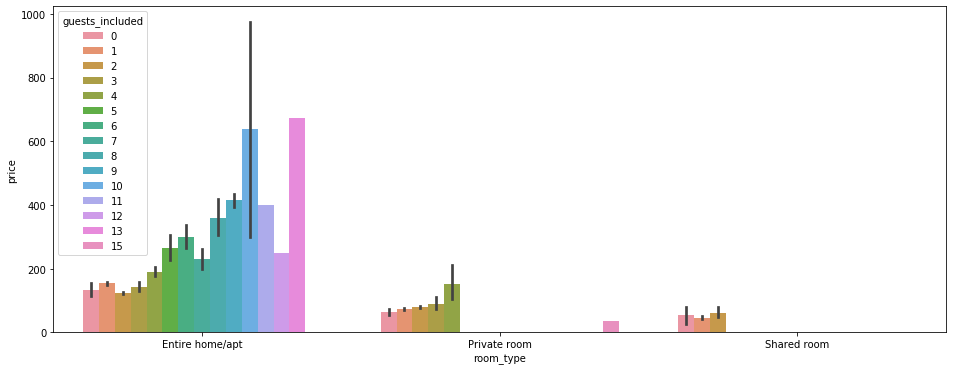

In [35]:
plt.figure(figsize=(16, 6))
sns.barplot(x="room_type", y="price", hue="guests_included", data=df_listings)

#### What are the room types most reviewed?

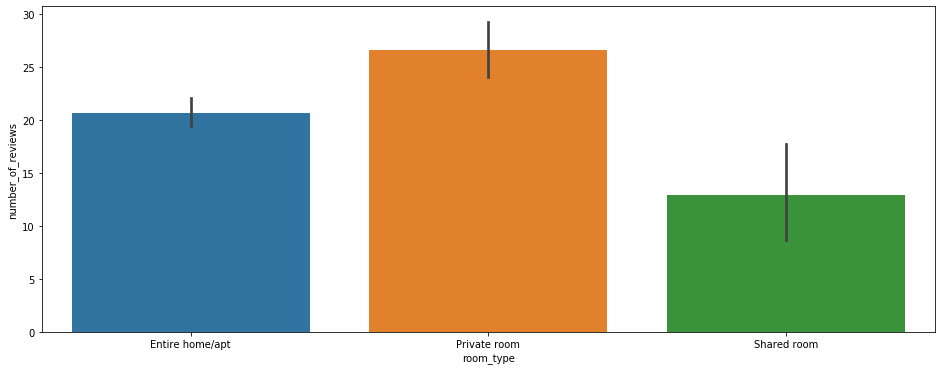

In [88]:
plt.figure(figsize=(16, 6))
sns.barplot(x="room_type", y="number_of_reviews", data=df_listings)

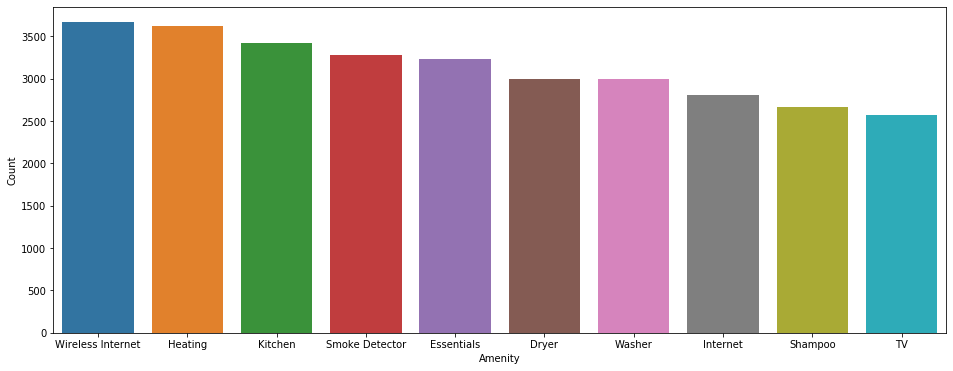

In [31]:
amt = df_listings['amenities'].apply(lambda x: [amenity.replace('"', "").replace("{", "").replace("}", "") 
                                               for amenity in x.split(",")])

mlb = MultiLabelBinarizer()
label_amt = pd.DataFrame(mlb.fit_transform(amt), columns=mlb.classes_, index=amt.index)

amt_count=label_amt.sum().sort_values(ascending=False)

d = {'Amenity': amt_count.index, 'Count': amt_count.values}
df_amt_count = pd.DataFrame(data=d)

plt.figure(figsize=(16, 6))
sns.barplot(x="Amenity", y="Count", data=df_amt_count.head(10))

Internet, Kitchen, heating, smoke detector and essentials are all that you need to feel at home and make some savings during a trip.

#### Price relation between instant bookable and room type

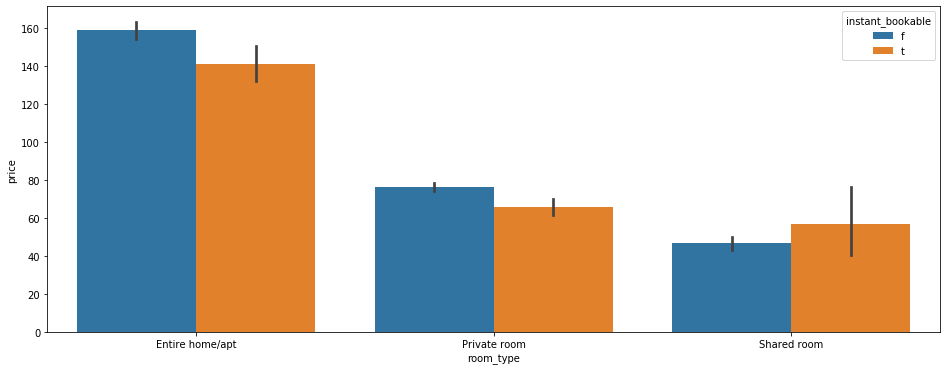

In [16]:
plt.figure(figsize=(16, 6))
sns.barplot(x="room_type", y="price", hue="instant_bookable", data=df_listings)

There is not a significant difference. However, it seems that private rooms, which are not instant bookeble available are more expensive

#### What months are cheaper to visit Seattle?

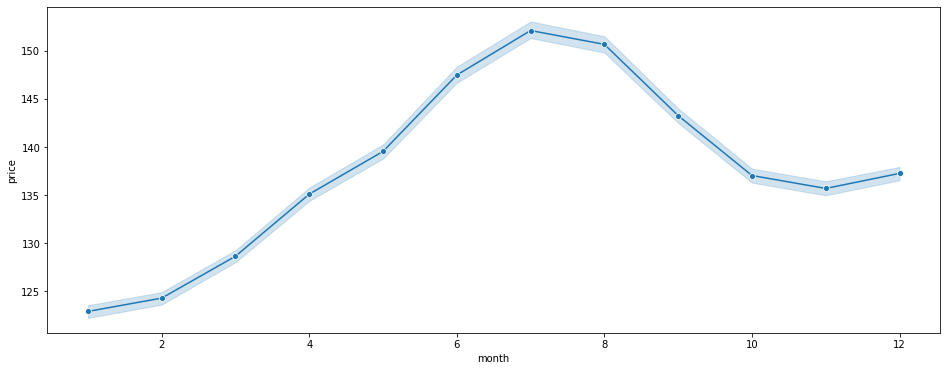

In [29]:
df_calendar['month'] = pd.DatetimeIndex(df_calendar['date']).month
df_calendar.dropna(subset=['price'], inplace=True)
df_calendar['price'] = df_calendar['price'].replace(r'[$,%]', '', regex = True).astype(float)

plt.figure(figsize=(16, 6))
sns.lineplot(x="month", y="price",marker="o", data=df_calendar)

June, July and August are the most expensive months to visit Seattle

####  What are features or characteristics that influence in the price of a room?

In order to answer this question, we need to move forward and in this case use a simple linear regression to predict price values and depending of the features, the accuracy may increase or not.

### Modeling


In order to have a simple approximation, I would based my featues based on review scores, section of the city, room type and number of bedrooms. I would for the moment discard features such as beds, bathrooms in order to see if we get some good feature representation to predict the price.

In [97]:
features = ['city',
            'price',
            'room_type',
            'bedrooms',
            'review_scores_accuracy',
            'review_scores_checkin',
            'review_scores_value',
            'review_scores_location',
            'review_scores_cleanliness',
            'review_scores_communication',
            'review_scores_rating',
            'reviews_per_month'
           ]

df_listings_reduced = df_listings[features]

# The decision he is remove all the rows with NaN values and as we saw before, they represent fex incompete rows (~17.23%)
df_listings_cleaned = df_listings_reduced.dropna()
df_listings_cleaned.shape

(3152, 12)

In [80]:
df_listings_cleaned.head()

,city,price,room_type,bedrooms,review_scores_accuracy,review_scores_checkin,review_scores_value,review_scores_location,review_scores_cleanliness,review_scores_communication,review_scores_rating,reviews_per_month
0,Seattle,85.0,Entire home/apt,1.0,10.0,10.0,10.0,9.0,10.0,10.0,95.0,4.07
1,Seattle,150.0,Entire home/apt,1.0,10.0,10.0,10.0,10.0,10.0,10.0,96.0,1.48
2,Seattle,975.0,Entire home/apt,5.0,10.0,10.0,10.0,10.0,10.0,10.0,97.0,1.15
4,Seattle,450.0,Entire home/apt,3.0,9.0,10.0,9.0,9.0,9.0,10.0,92.0,0.89
5,Seattle,120.0,Private room,1.0,10.0,10.0,10.0,10.0,10.0,10.0,95.0,2.45


In [98]:
# Now we will do some encodings fo city and room type
df_listings_encoded = pd.get_dummies(df_listings_cleaned, columns=['city', 'room_type'])
df_listings_encoded

,price,bedrooms,review_scores_accuracy,review_scores_checkin,review_scores_value,review_scores_location,review_scores_cleanliness,review_scores_communication,review_scores_rating,reviews_per_month,"city_Ballard, Seattle",city_Phinney Ridge Seattle,city_Seattle,city_Seattle,city_West Seattle,city_西雅图,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,85.0,1.0,10.0,10.0,10.0,9.0,10.0,10.0,95.0,4.07,0,0,1,0,0,0,1,0,0
1,150.0,1.0,10.0,10.0,10.0,10.0,10.0,10.0,96.0,1.48,0,0,1,0,0,0,1,0,0
2,975.0,5.0,10.0,10.0,10.0,10.0,10.0,10.0,97.0,1.15,0,0,1,0,0,0,1,0,0
4,450.0,3.0,9.0,10.0,9.0,9.0,9.0,10.0,92.0,0.89,0,0,1,0,0,0,1,0,0
5,120.0,1.0,10.0,10.0,10.0,10.0,10.0,10.0,95.0,2.45,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3810,154.0,2.0,9.0,10.0,8.0,10.0,8.0,10.0,92.0,1.56,0,0,1,0,0,0,1,0,0
3811,65.0,1.0,9.0,10.0,10.0,10.0,8.0,10.0,100.0,0.63,0,0,1,0,0,0,1,0,0
3812,95.0,1.0,10.0,10.0,10.0,9.0,10.0,10.0,96.0,4.01,0,0,1,0,0,0,1,0,0
3813,359.0,3.0,8.0,4.0,8.0,10.0,10.0,8.0,80.0,0.30,0,0,1,0,0,0,1,0,0


In [82]:
df_listings_encoded.columns

Index(['price', 'bedrooms', 'review_scores_accuracy', 'review_scores_checkin',
       'review_scores_value', 'review_scores_location',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_rating', 'reviews_per_month', 'city_Ballard, Seattle',
       'city_Phinney Ridge Seattle', 'city_Seattle', 'city_Seattle ',
       'city_West Seattle', 'city_西雅图', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')

In [83]:
# Here we start to do our model by a linear regression and introduce the features.

X = df_listings_encoded[['review_scores_accuracy',
                         'bedrooms',
                         'review_scores_checkin',
                         'review_scores_value',
                         'review_scores_location',
                         'review_scores_cleanliness',
                         'review_scores_communication',
                         'review_scores_rating',
                         'reviews_per_month',
                         'city_Ballard, Seattle',
                         'city_Phinney Ridge Seattle',
                         'city_Seattle', 
                         'city_Seattle ',
                         'city_West Seattle',
                         'city_西雅图', # This is Seattle in chinese (There is a very specific business niche)
                         'room_type_Entire home/apt',
                         'room_type_Private room',
                         'room_type_Shared room']]
# Price is assigned to y as predicted column.
y = df_listings_encoded['price']

# Create the test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

lm_model = LinearRegression(normalize=True) 

lm_model.fit(X_train, y_train) 

#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

### Evaluation


In [84]:
#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

#traing score
print('Train Score:', train_score)

#test score
print('Test Score', test_score)

Train Score: 0.5220793492152059
Test Score 0.4695097284035037


In the current model the r-squared value is 0.46 which is not too high for the test set. However, it will provide us an insight of features that may be replaced for other in order to improve the predictions.

In [85]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
1,bedrooms,56.834175,56.834175
17,room_type_Shared room,-53.629980,53.629980
12,city_Seattle,41.629513,41.629513
15,room_type_Entire home/apt,28.977239,28.977239
16,room_type_Private room,-23.896428,23.896428
9,"city_Ballard, Seattle",-19.841904,19.841904
3,review_scores_value,-16.493752,16.493752
4,review_scores_location,12.457234,12.457234
11,city_Seattle,-10.063477,10.063477
13,city_West Seattle,9.209943,9.209943


The following answer confirms that bedrooms, type of room and room location are the main drivers of the price and the reviews seems to not have impact in the price. However, they may have impact in the occupancy and revenue for the hosts. That would be another analysis to do in teh future.

### Deployment


In this case instead of deployin the code in a server production, I would share these insights in an article in Medium. The article can be found here:
[Article](https://medium.com/@jose0628/sea-2fe2b5cb49d) 

### Conclusions

We could see that the price of Airbnb is mostly driven by the number of bedrooms, location of the renting space and the type mostly. There is little evidence that reviews or the quality of the bed can increase the price per night. Moreover, internet, heating, kitchen and smoke detector seems to be the top ammenities offered in order to make you feel at home but it does not imply that the user may like it. Finally, the most expensive time of the year to visit Seattle is June, July and August.

All this information helps us to undertand better the Airbnb market in Seattle and thecode can be reused as a guidance for future Airbnb analyses in other locations.